# Chapter 3. Classification

- Now we will turn our attention to classification systems.

## MNIST

- In this chapter we will be using MNIST
    - A dataset comprised of 70,000 small images
    - Images represent handwritten digits by students & employees from the US census Bureau.
- Each image is labeled with the digit it represents
    - Ranging from 0 to 9
        - 10 Digits
- Scikit-learn provides many helper functions to download popular datasets:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml(name='mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

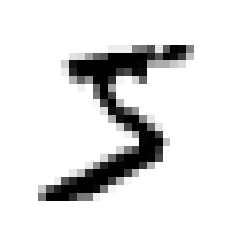

In [6]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

- Note that the label is a string, most algorithms expect numerical inputs so let's transform it:

In [8]:
y = y.astype(np.int8)

- But we should always start with splitting the data into train vs. test, right?

In [9]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

- Some ML algorithms are sensitive to ordered rows and can perform badly if instances from the same class are grouped together, the solution to this is to shuffle.
    - MNIST's training data is already shuffled for us.

## Training a Binary Classifier

- Let's simplify the problem for now and try to identify one digit (number **5**).
- This "5-detector" is an example of a binary classifier, it will predict, for any row, 5 or not-5.
- Let's create the target vector for the classification task:

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

- A good place to start is with a Stochastic Gradient Descent Classifier:

In [11]:
from sklearn.linear_model import SGDClassifier

In [12]:
sgd_clf = SGDClassifier(random_state=42)

In [13]:
sgd_clf.fit(X=X_train, y=y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

- Now we will use it to predict the digit of image at index 0:

In [14]:
sgd_clf.predict(X=[some_digit])

array([ True])

- .. and it's indeed a 5.
- Now let's evaluate this model's performance:

## Performance Measures

- Evaluating a classifier is often significantly trickier than evaluating a regressor.
- There are many performance measures available.

### Measuring Accuracy using Cross Validation

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [16]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [17]:
for train_index, test_index in skfolds.split(X=X_train, y=y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    num_correct = sum(y_pred == y_test_folds)
    print(num_correct / len(y_pred))

0.95035
0.96035
0.9604


- Alternatively, let's use `cross_val_score()` function to do Kfold cross validation where $K=3$:

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
scores = cross_val_score(estimator=clone(sgd_clf), X=X_train, y=y_train_5, cv=3, scoring="accuracy")
scores

array([0.95035, 0.96035, 0.9604 ])

- Above $95\%$ accuracy, isn't that great?
- Let's look at the performance of a very dumb classifier that classifies all training rows as "Not-5":

In [20]:
from sklearn.base import BaseEstimator

In [21]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros(shape=(len(X), 1), dtype=bool)

In [22]:
never_5_classifier = Never5Classifier()

In [23]:
scores = cross_val_score(estimator=never_5_classifier, X=X_train, y=y_train_5, cv=3, scoring="accuracy")
scores

array([0.91125, 0.90855, 0.90915])

- The dumb classifier has over 90% acccuracy for any validation.
- This hapenned because of the class imabalance in the binary task we are aiming for:
    - We originally had balanced counts for each digit.
    - But when we turned the problem into 5 vs. non-5, we end up with the first class taking ~10% of the rows and non-5 taking >=90%.
    - Hence, if you created a dumb model that just predicts "non-5" for any input, you'll get at least 90% accuracy.
- This demonstrates why accuracy is generally not the preferred method to evaluate classifiers, especially if the data have imbalanced classes.

### Confusion Matrix

- A much better way to evaluate the performance of a classifier is to look at its produced confusion matrix.
- Let's use `cross_val_predict()` to get some predictions to finally visualize the confusion matrix:

In [24]:
from sklearn.model_selection import cross_val_predict

In [25]:
y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3)

In [26]:
y_train_pred.shape

(60000,)

- `corss_val_predict` returns the predictions made of the test fold.
    - And because we are looping over the 3 folds, we endup with predictions for all data.
- Let's take a look at the confusion matrix:

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(y_true=y_train_5, y_pred=y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- Each row in the confusion matrix represents an actual class. While each column represents a predicted class.
    - first row is "not 5"
        - Model correctly predicted "not 5" for 54K "not 5"s
            - True Negatives
        - Model incorrectly predicted "5" for 687 "not 5"s
            - False Positive
    - second row is "5"
        - Model incorrectly predicted "not 5" for 1891 "5"s
            - False Negative
        - Model correctly predicted "5" for 3530 "5"s
            - True Positives
- A perfect classifier would have only True Positives and True negatives, meaning the confusion matrix will have zeros on all elements except its diagonal.
- Let's pretend we reached perfection:

In [29]:
y_train_perfect_predictions = y_train_5.copy()

In [30]:
confusion_matrix(y_true=y_train_5, y_pred=y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- The confusion matrix gives you a lot of information, but sometimes you may prefer a single-number metric.
- An interesting one to look at is the model's accuracy over its positive predictions, named *precision*:

$$precision = \frac{TP}{TP+FP}$$

- A trivial way to have a perfect precision of $1$ is to make one prediction that you're sure it's correct, by consequence $FP=0$ and $precision=1$.
    - This would not be useful since the evaluation is ignore all but the true positives.
- Precision is typically used along with another metric named recall.
- recall, also called sensitivity or the True Positive rate is as follows:

$$recall = \frac{TP}{TP+FN}$$

### Precision & Recal

In [31]:
from sklearn.metrics import precision_score, recall_score

In [32]:
precision_score(y_true=y_train_5, y_pred=y_train_pred)

0.8370879772350012

In [33]:
recall_score(y_true=y_train_5, y_pred=y_train_pred)

0.6511713705958311

- The recall score is not good at all.
    - its dominator consists of TPs & **False Negatives**, we can conclude that our model is predicting a lot of digits as not "5" but they're "5"s.
    - The model is not good at predicting False Negatives.
- Now our model doesn't look as shiny as it was when we looked at its accuracy.
- When it claims that a digit represents a "5" it's only correct for $83\%$ of the times.
- It's often convinient to combine the precision and accuracy scores into a single metric called the $F_{1}$ score.
    - In particular, if you want to compare two classifiers.
    - The $F_{1}$ score represents the harmonic mean of the precision & recall metrics.
        - Harmonic because it gives more importance to low values in its formula.
        - Meaning, the F1 score will only give you high scores if both precision and recall are high.

$$F_{1}=\frac{2}{{1 \over precision}+{1 \over recall}}=2 \times \frac{precision \times recall}{precision + recall}$$

In [34]:
from sklearn.metrics import f1_score

In [35]:
f1_score(y_true=y_train_5, y_pred=y_train_pred)

0.7325171197343846

- The $F_{1}$ favors classifiers that have similar precision and recall.
- This is not always what you want
    - Sometimes you only care about precision
        - Or the relation between True Positives and **False Positives**
            - Ex. You don't want to incorrectly predict that a transaction is fraudulous.
            - Ex. You don't want to incorrectly predict that a video is safe for kids to watch.
                - But you don't care that much if you incorrectly predict that a video is bad.
    - And other times you only care about recall
        - Or the relation between True Positives and **False Negatives**
            - Ex. You don't want to incorrectly predict that a person doesn't have cancer.
- Unfortunately, you can't have it both ways, increasing precision will decrease recall, and increasing recall decreases precision.
    - This is called the precision-recall trade-off.

### Precision-Recall Trade-off

- To understand this trade-off, we need to know how the algorithm is making its decisions.
- For each instance, the classifier outputs a score (we can call it a probability)
- If the score is higher than a certain threshold, we label the instance as positive (a "5")
- If the score is less than the threshold, we the instance as negative (a "not 5")

<div style="text-align:center"><img style="width: 50%" src="static/imgs/precision-recall-trade.png" /></div>

- As you can notice, if we raise the threshold, precision converges to $100%$, but as a result, we lower the recall.
    - Same happens to recall if we lower the threshold, we get a better recall (False Negatives are fewer) but we decrease precision. 
- Scikit-learn doesn't allow you to set the threshold directly, but it can give you the scores for each of its prediction.
    - You can set the threshold you want after getting the scores:

In [36]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [37]:
threshold = 0

In [38]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- Let's raise the threshold:

In [39]:
threshold = 8000

In [40]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- How do you decide which threshold to use?

In [41]:
y_scores = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, 
                             cv=3, method='decision_function', n_jobs=-1)

- With these decision scores, use another function to compute the recalls/precisions for all possible threshold:

In [42]:
from sklearn.metrics import precision_recall_curve

In [43]:
precision, recall, thresholds = precision_recall_curve(y_true=y_train_5, probas_pred=y_scores)

- Finally, use `matplotlib` to plot precision and recall in function of the threshold value:

In [44]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.grid()

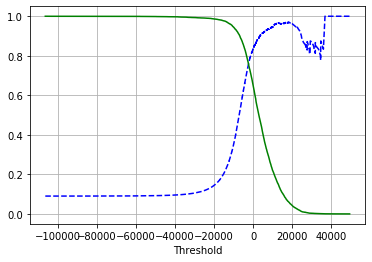

In [45]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.show()

- You may wonder why the precision curve is bumpier than the recall curve.
    - The reason is that the precision may sometimes go dows when you raise the threshold.
    - You may lose precision by upping the threshold if you lose TPs while the FPs are still there
    - But generally, precision should increase.
- On the other hand recall is very smooth because..
    - Because we we add another TN while moving the threshold, nothing changes in the score.
- Another way to select a good precision and recall trade-off is to plot precision directly against recall:

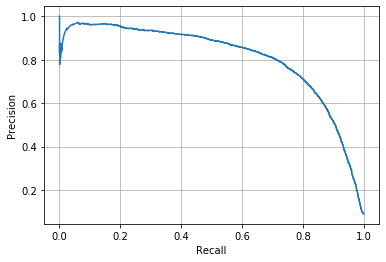

In [46]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

- You can see the precision really starts to fall sharply around 80% recall.
- You would probably want to select a precision/recall trade-off just before **that drop**.
    - For example, at around $60\%$ recall.
        - But ofcoures, the choice depends on your project.
- Suppose you want to aim for $90\%$ precision, you would look up the first graph to get the threshold
    - and lookup the second graph to find the best Recall you can get with a precision of $90\%$.
- Implementation: Search for the lowest threshold that give at least $90\%$ precision score:

In [47]:
threshold_90_precision = thresholds[np.argmax(precision > .9)]
threshold_90_precision

3370.0194991439557

- To make predictions for the training set, you first get the score of the desired point and compare the score to the chosen threshold:

In [48]:
y_train_pred_90 = (y_scores > threshold_90_precision)

- Let's check these predictions' precision and recall:

In [49]:
precision = precision_score(y_true=y_train_5, y_pred=y_train_pred_90)
precision

0.9

In [50]:
recall = recall_score(y_train_5, y_train_pred_90)
recall

0.47980077476480354

- But remember that a high precision classifier is not good at all with a low recall.
- If someone shouts: "Let's reach a 99% precision score", you should ask: "But at what Recall?"

### The ROC Curve

- The receiver operating characteristic curve is another tool used with binary classifiers.
- ROC plots TP rate versus FP rate
    - ROC plots recall versus 1 - specificity

In [51]:
from sklearn.metrics import roc_curve

In [52]:
fpr, tpr, thresholds = roc_curve(y_true=y_train_5, y_score=y_scores)

In [53]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--', label='Random')
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

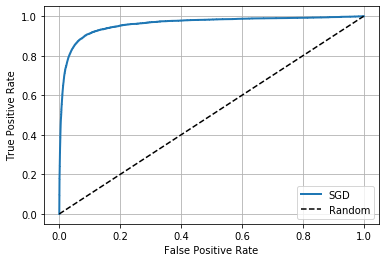

In [54]:
plot_roc_curve(fpr, tpr, label='SGD')
plt.legend(loc='lower right')
plt.show()

- The Higher the recall, the more false positives the model produces.
- The dotted line represent the ROC curve of a completely random classifier.
- A good classifier stays as far a way as possible from the dotted line.
- One way to compare classifiers is to measure the area under the curve (AUC).
    - A perfect classifier will have an ROC AUC of 1.
    - A purely random classifier will have an ROC AUC of 0.5.
- Example:

In [55]:
from sklearn.metrics import roc_auc_score

In [56]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- Let's now train a `RandomForestClassifier` to compare its ROC Curve and ROC AUC score to the `SGDClassifier`'s:

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
forest_clf = RandomForestClassifier(random_state=42)

In [59]:
y_probas_forest = cross_val_predict(estimator=forest_clf, X=X_train, 
                                    y=y_train_5, cv=5, 
                                    n_jobs=-1, method='predict_proba')

In [60]:
y_scores_forest = y_probas_forest[:, 1]  # P(X=5)

In [61]:
fpr_forest, tps_forest, threshs_forest = roc_curve(y_true=y_train_5, y_score=y_scores_forest)

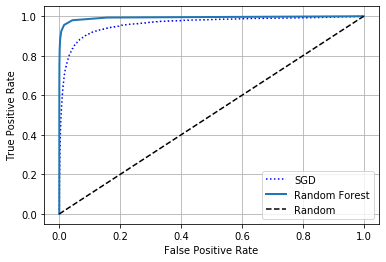

In [62]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tps_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

- We can see that `Random Forest classifier` is superior to `SGD` because its curve is much closer to the top left corner of the graph.
- Let's check its area under the curve (AUC):

In [63]:
roc_auc_score(y_train_5, y_scores_forest)

0.9933511587661912

- Let's measure the precision & recall for `RF`:

In [64]:
y_preds_forest = cross_val_predict(estimator=forest_clf, X=X_train, 
                                   y=y_train_5, cv=5, 
                                   n_jobs=-1)

In [65]:
precision_score(y_true=y_train_5, y_pred=y_preds_forest)

0.9845450587723117

In [66]:
recall_score(y_true=y_train_5, y_pred=y_preds_forest)

0.8343479062903524

- You now know how to ...
    - train classifiers
    - choose the appropriate metric for your task
    - evaluate your classifier using cross-validation
    - select the precision-recall ratio that fits your needs
    - use ROC and ROC AUC to compare various models.
- Time to move to multiclass classification (beyond binary classification):

## Multiclass Classification

- There are techniques you can use to perform multiclass classification with binary classifiers.
- One way to create a system that can classify an image into 10 labels (from 0 to 9) is to train 10 binary classifiers.
    - One for each digit.
    - Then when you want to classify an image, you get each classifier's associated positive score and just pick the model class w/ the highest score.
    - This is called one-versus-the-rest startegy, or 1-vs-all.
- Another startegy is to train a binary classifier for each pair of digits.
    - This is called 1-vs-1.
    - If there are $N$ classes, you need to train $N \times (N-1) \over 2$.
    - For the MNIST Problem, this means training $45$ binary classifiers.
    - **and see which class wins the most duals**.
    - Even though we need to create many classifiers, they are needed to be trained on only the data points where one of the classes appeared.
- Scikit-learn detects when you try to use a binary classification algorithm for a multiclass classification problem
    - It then automatically use OvO or OvR depending on the algorithm to train.

In [67]:
from sklearn.svm import SVC

In [68]:
svm_clf = SVC()

In [72]:
svm_clf.fit(X=X_train[:10000], y=y_train[:10000])

//miniconda3/envs/research/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [73]:
svm_clf.predict([some_digit])

array([5], dtype=int8)